In [17]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
movie_file = Path("Movie_RawDataset.csv")

movie_df = pd.read_csv(movie_file)

movie_df.head()

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre,Movie Rated,Language,Awards,Rotten Tomatoes Rating,IMDb Rating,Metascore,IMDb ID,Box Office,Rotten Tomatoes,imdbID
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,Gross Unkown,Action,"Adventure, Drama",Not Rated,Kannada,12 wins & 8 nominations,80%,8.2,NaN,NaN,NaN,Rating not found,tt15327088
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama",PG-13,"English, Mandarin",Won 2 Oscars. 163 wins & 164 nominations total,94%,9.0,84,NaN,"$534,987,076",Rating not found,tt0468569
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama",PG-13,"English, Quenya, Old English, Sindarin",Won 11 Oscars. 215 wins & 124 nominations total,94%,9.0,94,NaN,"$379,427,292",Rating not found,tt0167260
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi",PG-13,"English, Japanese, French",Won 4 Oscars. 159 wins & 220 nominations total,87%,8.8,74,NaN,"$292,587,330",Rating not found,tt1375666
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama",PG-13,"English, Sindarin, Old English",Won 2 Oscars. 132 wins & 138 nominations total,95%,8.8,87,NaN,"$342,952,511",Rating not found,tt0167261


In [3]:
movie_df = movie_df.rename(columns={"Movie Rated":"Movie_Rate", "IMDb Rating": "IMDb_Rating",
                                    "Rotten Tomatoes Rating":"Rotten_Tomatoes_Rating", "IMDb ID":"IMDb_ID",
                                    "Box Office":"Box_Office", "Rotten Tomatoes":"Rotten_Tomatoes"})
del movie_df['IMDb_ID']

# movie_df = movie_df[movie_df["Awards"] != "Awards not found"]
# movie_df['Director'].value_counts()

### The input cell below groups the data by "Single Director" and "Multiple Directors"

In [ ]:
# Create a new column "Director_Type" based on the number of directors
movie_df['Director_Type'] = movie_df['Director'].apply(lambda x: 'Multiple Directors' if ',' in x else 'Single Director')

# Group the DataFrame by the "Director_Type" column
grouped_director_type = movie_df.groupby('Director_Type')

# Print the count of movies in each group
for director_type, group in grouped_director_type:
    print(f"Director Type: {director_type}")
    print(group[['Movie_Title', 'Director']])
    print()


grouped_director_type.head()

### The input cell below splits "Multiple Directors" into individual elements

In [85]:
# Identify rows with multiple directors
multiple_directors_mask = movie_df['Director'].str.contains(',')

# Split multiple directors into individual values and create new rows
multiple_directors_df = movie_df[multiple_directors_mask].copy()
multiple_directors_df['Director'] = multiple_directors_df['Director'].str.split(', ')
multiple_directors_df = multiple_directors_df.explode('Director')

# Combine the original DataFrame with the new rows for multiple directors
updated_movie_df = pd.concat([movie_df[~multiple_directors_mask], multiple_directors_df], ignore_index=True)

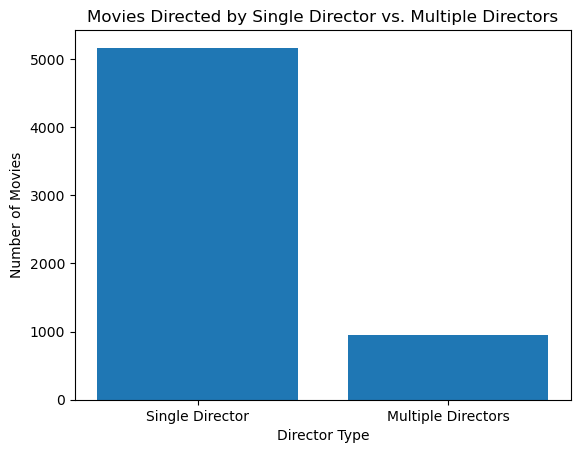

Of the ~6000 Top Movies, 84.4% were directed by an individual director, whereas 15.6% were directed by multiple directors


In [32]:
director_counts = updated_movie_df['Director_Type'].value_counts()
plt.bar(director_counts.index, director_counts.values)
plt.xlabel('Director Type')
plt.ylabel('Number of Movies')
plt.title('Movies Directed by Single Director vs. Multiple Directors')
plt.show();
single_director_percent = 5167 / 6122 * 100
rounded_single = round(single_director_percent, 2)
multiple_director_percent = 955 / 6122 * 100
rounded_multiple = round(multiple_director_percent, 2)
print(f"Of the ~6000 Top Movies, {rounded_single}% were directed by an individual director, whereas {rounded_multiple}% were directed by multiple directors")

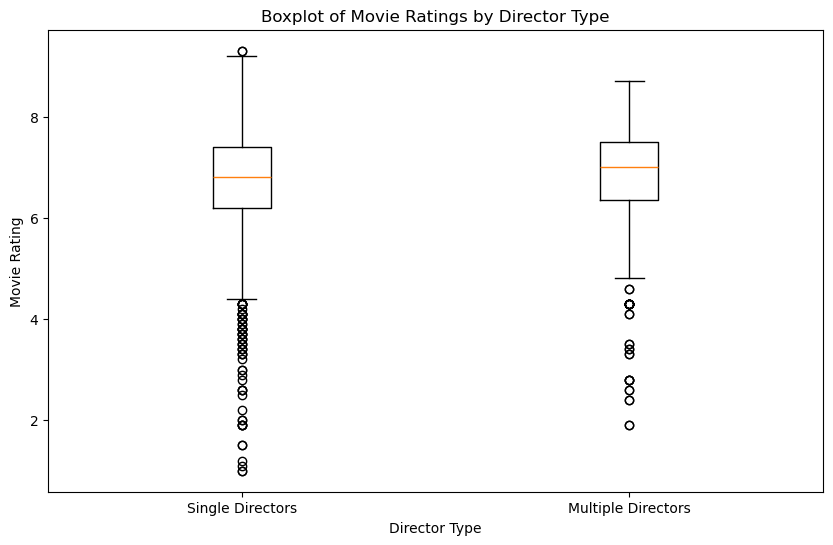

In [48]:
# Separate the data for Single Directors and Multiple Directors
single_directors_ratings = updated_movie_df[updated_movie_df['Director_Type'] == 'Single Director']['Rating']
multiple_directors_ratings = updated_movie_df[updated_movie_df['Director_Type'] == 'Multiple Directors']['Rating']

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([single_directors_ratings, multiple_directors_ratings], labels=['Single Directors', 'Multiple Directors'])
plt.xlabel('Director Type')
plt.ylabel('Movie Rating')
plt.title('Boxplot of Movie Ratings by Director Type')
plt.show()
# Not sure if this is something noteable, but I'll save it just in case. Mean rating (red line) for Single Directors is 6.75, 
# while the mean rating for multiple directors is 6.84.

In [ ]:
updated_movie_df2 = updated_movie_df[updated_movie_df['Box_Office'] != 'Box Office not found']
updated_movie_df2 = updated_movie_df.dropna(how='any')
updated_movie_df2['Box_Office'] = updated_movie_df2['Box_Office'].str.replace('[\$,]', '', regex=True).astype(int)

box_and_directortype = updated_movie_df2[['Box_Office', 'Director_Type']]

single_directors_box = box_and_directortype[box_and_directortype['Director_Type'] == 'Single Director']['Box_Office']
multiple_directors_box = box_and_directortype[box_and_directortype['Director_Type'] == 'Multiple Directors']['Box_Office']
# plt.boxplot([single_directors_box, multiple_directors_box], labels=['Single Directors', 'Multiple Directors'])
# plt.xlabel('Director Type')
# plt.ylabel('Box Office (USD)')
# plt.show();

#I'm still trying to figure this out